<div>
<img src="https://notebooks.dtcglaciers.org/_images/ESA_logo.svg" width="160" align='right'/>
</div>

# Validating DTC-Glaciers EO-DT-Enhanced Data cubes (L2)

If required, install the DTCG API using the following command:

```
!pip install 'dtcg[jupyter] @ git+https://github.com/DTC-Glaciers/dtcg'
```

Run this command in a notebook cell.

In [1]:
# Imports
import xarray as xr
import matplotlib.pyplot as plt

To asses the performance of different **L2** data cubes this notbook illustrates the capabilities of the **DTC-Glaciers validation framework**. The goal is to use available data from the **L1** data cubes for valiation of corresponding **L2** data cubes.

We start by opening two examples from the preprocessed **L2** data cubes:

In [2]:
rgi_id_ice = "RGI60-06.00377"  # Brúarjökull
rgi_id_aut = "RGI60-11.00719"  # Vernagtferner

def get_l2_data_tree(rgi_id):
    l2_datacube_url = "https://cluster.klima.uni-bremen.de/~dtcg/datacubes_case_study_regions/L1_and_L2/"
    return xr.open_datatree(
            f"{l2_datacube_url}{rgi_id}.zarr",
            chunks={},
            engine="zarr",
            consolidated=True,
            decode_cf=True,
        )

data_tree_ice = get_l2_data_tree(rgi_id_ice)
data_tree_aut = get_l2_data_tree(rgi_id_aut)

## Validation of DTC-Glaciers output

The **validation** within DTC-Glaciers consist of a mix of using **in-situ observations** as well as **EO data** from our **L1** data cubes. The entire validation framework is build around the `DatacubeValidator`, which only needs a data tree as input:

We asses the performance of different **L2** data cubes with regards to observations, by calculating the following metrics:

In [4]:
validator_ice.get_description_of_metrics()

{'MeanAbsD': 'Mean Absolute Deviation',
 'MeanD': 'Mean Deviation',
 'MedianD': 'Median Deviation',
 'RMSD': 'Root Mean Squared Deviation',
 'CORRCOEF': 'Pearson correlation coefficient'}

To account for **observation** and **model uncertainty** during validation, we rely on **[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))**. In addition to evaluating the **performance metrics** using the **most likely** observation and model values, we generate a **distribution** for each metric. This is done by repeatedly **resampling the time series** in coherent multi-year blocks and **drawing** a plausible value for each resampled year from the corresponding **uncertainty description**. For **observations**, we assume a **normal distribution**, while the **model output** is represented by **seven quantiles** (0.05, 0.15, 0.25, 0.5, 0.75, 0.85, and 0.95). By default, this procedure is **repeated 5000 times**, and the resulting sampling distribution is summarized using a **90% confidence interval**, which is shown in brackets in the validation output below.

Below we show two examples of the validation framework, for our two case study regions with different data availablility. 

## Iceland

In Iceland we have EO-data from **[CryoTEMPO-EOLIS](https://cryotempo-eolis.org/)** (CryoSat-2) available as well as for some glaciers in-situ observations from **[WGMS](https://wgms.ch/)**.

Let's see which **L2** data cubes we have available:

In [5]:
list(data_tree_ice.keys())

['L1',
 'L2_Daily_Cryosat_2011_2020',
 'L2_Daily_Hugonnet_2000_2020',
 'L2_Daily_Hugonnet_2010_2020',
 'L2_SfcDaily_Cryosat_2011_2020',
 'L2_SfcDaily_Hugonnet_2000_2020',
 'L2_SfcDaily_Hugonnet_2010_2020']

For the following analysis, we selected the Daily model calibrated with **[CryoTEMPO-EOLIS](https://cryotempo-eolis.org/)** (CryoSat-2) for the period 2011–2020 and compared it to the same model calibrated with **[Hugonnet et al. (2021)](https://doi.org/10.1038/s41586-021-03436-z)** for the period 2010–2020, which is the default dataset used in OGGM v1.6.2.

In [6]:
l2_list_ice = ['L2_Daily_Cryosat_2011_2020', 'L2_Daily_Hugonnet_2010_2020']

With the already set-up `DatacubeValidator` we only need to provide the **L2** data cubes we are interested in and the validator looks which data is available in the **L1** data cubes and calculates the performance metrics:

In [7]:
validation_data_ice, bootstrap_args_ice = validator_ice.get_validation_for_layers(
    l2_name_list=l2_list_ice, return_bootstrap_args=True)

Let's start by looking at the results of comparing the **L2** data cubes to the CryoSat-2 observation:

In [8]:
validation_data_ice['CryoSat2']

,MeanAbsD (m),MeanD (m),MedianD (m),RMSD (m),CORRCOEF
L1 CryoSat2 elevation change 2011-01-01_2025-05-01,,,,,
L2_Daily_Cryosat_2011_2020,"0.6 (0.8, 1.1)","0.2 (-0.2, 0.4)","0.1 (-0.2, 0.5)","0.7 (1.1, 1.4)","0.75 (0.31, 0.57)"
L2_Daily_Hugonnet_2010_2020,"3.4 (2.5, 4.5)","-3.4 (-4.4, -2.4)","-4.1 (-4.6, -1.4)","4.1 (3.4, 5.1)","0.55 (0.17, 0.58)"


We see that the data cube calibrated with Cryosat outperfoms the Hugonnet one. We can see smaller values in the metrics quantiving absolute differnces (`MeanAbsD`, `RMSD`). Further metrics quantifiying a bias (`MeanD` and `MedianD`) are closer to zero, with confidence intervalls with changing signs. Finally, also the correlation coefficient is larger indicating a stronger linear relationship between observations and model output.

To help with interpretation we also can have a look at the bootstrap settings used during the validation:

In [9]:
bootstrap_args_ice['CryoSat2']

{'ci_level': 0.9, 'n': 173, 'n_boot': 5000, 'block_length': 13, 'seed': 0}

We see that the provided intervalls of metrics correspond to a 90% confidence intervall (`ci_level`), in total 173 observations are available (`n`), that 5000 individual resamplings of the timeseries and evalutaions of the metrics where performed (`n_boot`) and the coherent block length was 13 observations (`block_length`). For reproducebility we use a constant random `seed`. 

However we need to take into account that the above validation is not independent as the Cryosat data cube used parts of this data vor calibration. Theirfore, we also can have a look solely on the independent data by defining a validation period:

In [10]:
validation_cryosat_2020_2025 = validator_ice.get_validation_for_layers(
    l2_name_list=l2_list_ice,
    baseline_date='2020-01-01',  # the date where the cumulated elevation change starts
    obs_list=['CryoSat2'],  # we can select to only perform the validation on one observation
    validation_period='2020-01-01_2025-12-31',)  # define the period which should be considered

validation_cryosat_2020_2025['CryoSat2']

,MeanAbsD (m),MeanD (m),MedianD (m),RMSD (m),CORRCOEF
L1 CryoSat2 elevation change 2020-01-01_2025-05-01,,,,,
L2_Daily_Cryosat_2011_2020,"0.6 (0.7, 1.0)","0.5 (0.3, 0.8)","0.4 (0.2, 0.8)","0.8 (0.9, 1.3)","0.88 (0.52, 0.78)"
L2_Daily_Hugonnet_2010_2020,"1.0 (0.9, 1.4)","-0.9 (-1.2, -0.5)","-0.8 (-1.2, -0.4)","1.3 (1.1, 1.7)","0.80 (0.50, 0.77)"


Also when using the independent validation period, we see that the Cryosat data cube still outperforms the Hugonnet data cube, however differences are not as pronounced as when using the entire period.

We also can use the `DatacubeValidator` to get a visual impression of the performance by creating comparision plots. For the entire period:

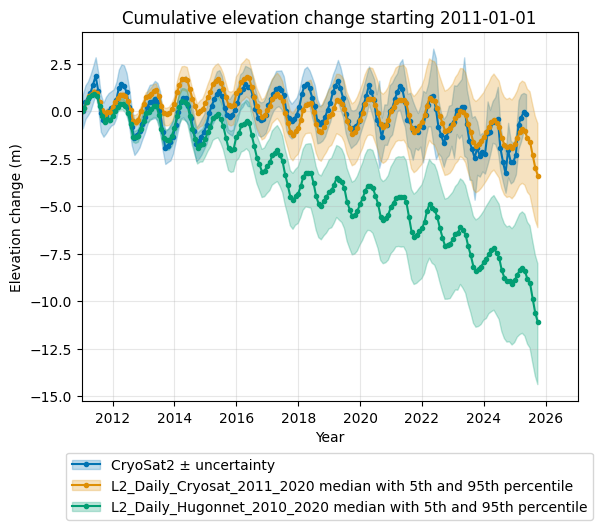

In [11]:
validator_ice.get_validation_plot_for_layers(l2_name_list=l2_list_ice, obs_name='CryoSat2')
plt.show()

Or for the independent period, by defining a `baseline_date`:

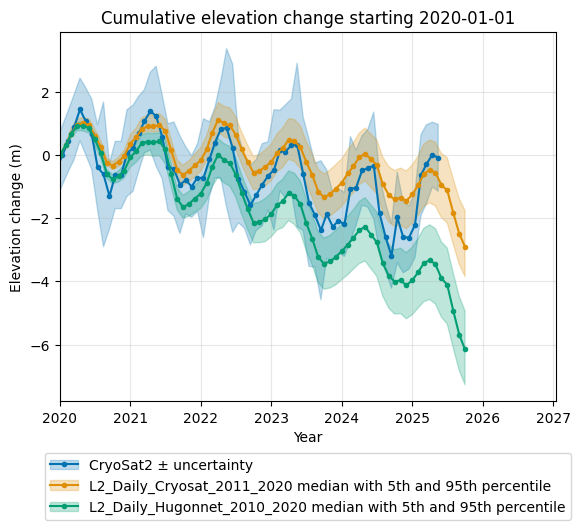

In [12]:
fig = validator_ice.get_validation_plot_for_layers(l2_name_list=l2_list_ice, obs_name='CryoSat2',
                                                   baseline_date='2020-01-01')
plt.show()

Another available data source for our test glacier are in-situ mass balance obsevations from **[WGMS](https://wgms.ch/)**:

In [13]:
validation_data_ice['WGMS']

,MeanAbsD (mm w.e. yr-1),MeanD (mm w.e. yr-1),MedianD (mm w.e. yr-1),RMSD (mm w.e. yr-1),CORRCOEF
L1 WGMS annual mass balance 2000-2024,,,,,
L2_Daily_Cryosat_2011_2020,"437.6 (375.2, 506.4)","98.9 (-40.2, 282.4)","89.9 (-51.6, 274.2)","539.9 (460.9, 642.8)","0.49 (0.27, 0.71)"
L2_Daily_Hugonnet_2010_2020,"515.2 (375.0, 640.3)","-298.1 (-449.1, -113.9)","-308.1 (-479.9, -127.2)","622.5 (478.3, 756.1)","0.48 (0.24, 0.70)"


In [14]:
bootstrap_args_ice['WGMS']

{'ci_level': 0.9, 'n': 25, 'n_boot': 5000, 'block_length': 5, 'seed': 0}

Also for this data the Cryosat data cube outperformes the Hugonnet data cube in most metrics, illustrating the added value of the EO-data.

Visualisations are also available for the in-situ data:

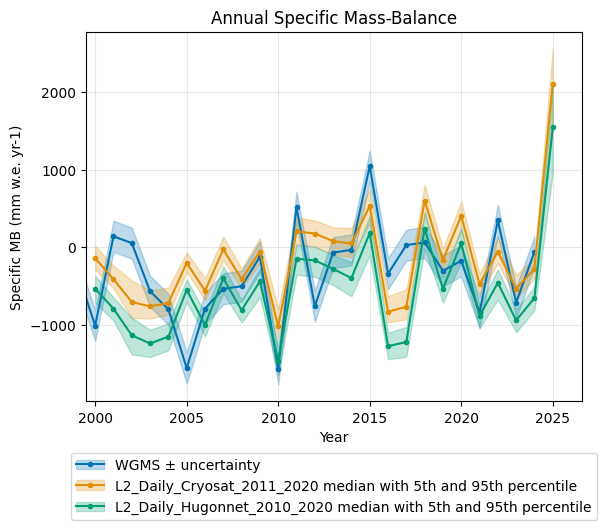

In [15]:
validator_ice.get_validation_plot_for_layers(l2_name_list=l2_list_ice, obs_name='WGMS')
plt.show()

## Austria

In Austria we have EO-data from **[ENVEO](https://www.enveo.at/)** (Sentinel-2) available as well as for some glaciers in-situ observations from **WGMS**. [See this notebook](01_L1_datacubes.ipynb) for further explanations about the available data. Let's see which **L2** data cubes we have available:

In [16]:
list(data_tree_aut.keys())

['L1',
 'L2_Daily_Hugonnet_2000_2020',
 'L2_Daily_Hugonnet_2010_2020',
 'L2_SfcDaily_Hugonnet_2000_2020',
 'L2_SfcDaily_Hugonnet_2010_2020']

In this case we compare the influence of two different mass balance models, which rely on the same calibration data from **[Hugonnet et al. (2021)](https://doi.org/10.1038/s41586-021-03436-z)** in the period 2010 to 2020. The daily model is a simple temperature index model, which is the same as the [OGGM v1.6.1 default](https://docs.oggm.org/en/v1.6.2/mass-balance-monthly.html), but with a daily resolution. The second model is a temperature index model, enhanced with a bucket system for snowtracking and was implemented following [Schuster et al. 2023](https://doi.org/10.1017/aog.2023.57) and the [OGGM Mass-Balance sandbox](https://github.com/OGGM/massbalance-sandbox).

In [17]:
l2_list_aut = ['L2_Daily_Hugonnet_2000_2020', 'L2_SfcDaily_Hugonnet_2000_2020']

validation_data_aut, bootstrap_args_aut = validator_aut.get_validation_for_layers(
    l2_name_list=l2_list_aut, return_bootstrap_args=True)

Not all data available for Sentinel2


You see a warning message shown, which indicates that some data cubes are missing data for the validation. The reason is that for the validation with Sentinel-2 data we need a modelled snowline, and this is only available when using the newly implemented snowtracking bucket sysetm. But more on this later, first we have a look at the WGMS validation:

In [18]:
validation_data_aut['WGMS']

,MeanAbsD (mm w.e. yr-1),MeanD (mm w.e. yr-1),MedianD (mm w.e. yr-1),RMSD (mm w.e. yr-1),CORRCOEF
L1 WGMS annual mass balance 2000-2024,,,,,
L2_Daily_Hugonnet_2000_2020,"298.1 (243.6, 372.3)","-33.4 (-186.9, 13.6)","-108.8 (-233.9, -3.7)","361.3 (306.8, 454.1)","0.86 (0.67, 0.91)"
L2_SfcDaily_Hugonnet_2000_2020,"330.2 (287.5, 439.7)","-70.2 (-245.7, -12.2)","-60.8 (-240.4, 46.0)","423.0 (367.1, 549.5)","0.89 (0.73, 0.93)"


In [19]:
bootstrap_args_aut['WGMS']

{'ci_level': 0.9, 'n': 25, 'n_boot': 5000, 'block_length': 5, 'seed': 0}

The comparision of the two options shows slightly better performance for the daily model without snowtracking. Let's visualize the data:

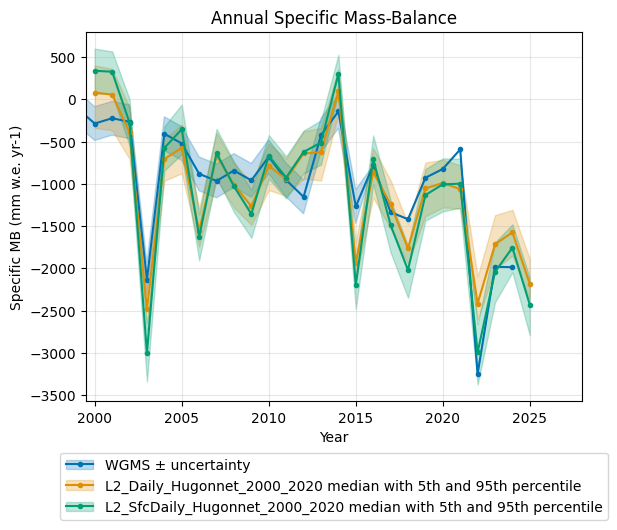

In [20]:
validator_aut.get_validation_plot_for_layers(l2_name_list=l2_list_aut, obs_name='WGMS')
plt.show()

For surface tracking we see that the extreme year 2022 is much better captured. This probably could be related to the fact that with the bucket system albedo feedbacks are included and the very early snowfree glacier surface in 2022 led to a darker surface and hence more ablation. However, the newly developed bucket system need further research and developments to become operational.

A potential new way in the future could be to utilize snowline observations for assimilation. Through the inclusion of surface tracking we are able to utilize this new type of EO data. In particular we are able to use snowline altitudes derived from Sentinel-2. In the current implementation we are using this data only for validation, but with future developments it should become possible to also use this data in the assimilation pipeline.

The validation metrics of this first implementation looks like this:

In [21]:
validation_data_aut['Sentinel2']

,MeanAbsD (m),MeanD (m),MedianD (m),RMSD (m),CORRCOEF
L1 Sentinel2 snowline 2015-07-04_2021-09-25,,,,,
L2_SfcDaily_Hugonnet_2000_2020,"109.5 (93.1, 133.6)","13.8 (-38.1, 55.5)","15.5 (-0.2, 15.5)","169.0 (139.4, 206.3)","0.80 (0.71, 0.87)"


And the modelled snowline evolution can also be vizualized together with the observations:

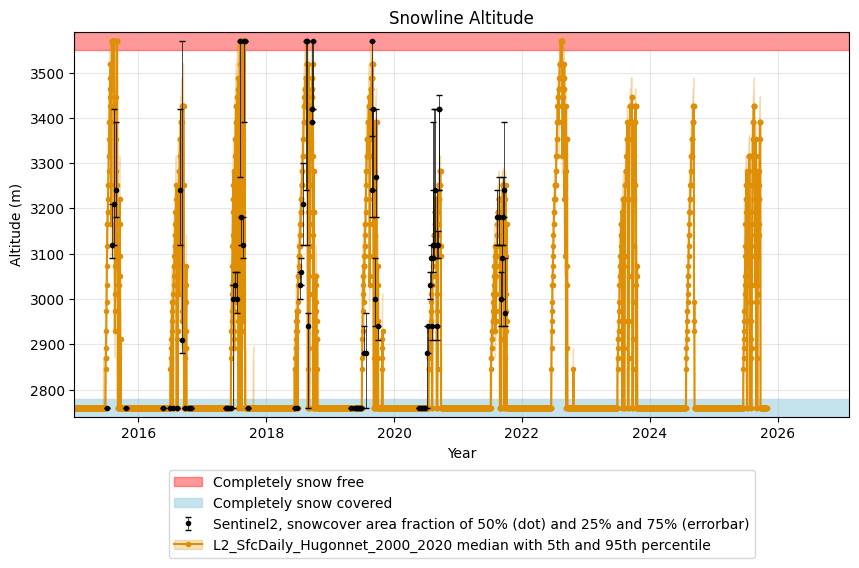

In [22]:
validator_aut.get_validation_plot_for_layers(l2_name_list=l2_list_aut, obs_name='Sentinel2',)
plt.show()

The plot is quite packed when looking at the full period, theirfor you also could use `x_lim` for zooming in to a period of interest:

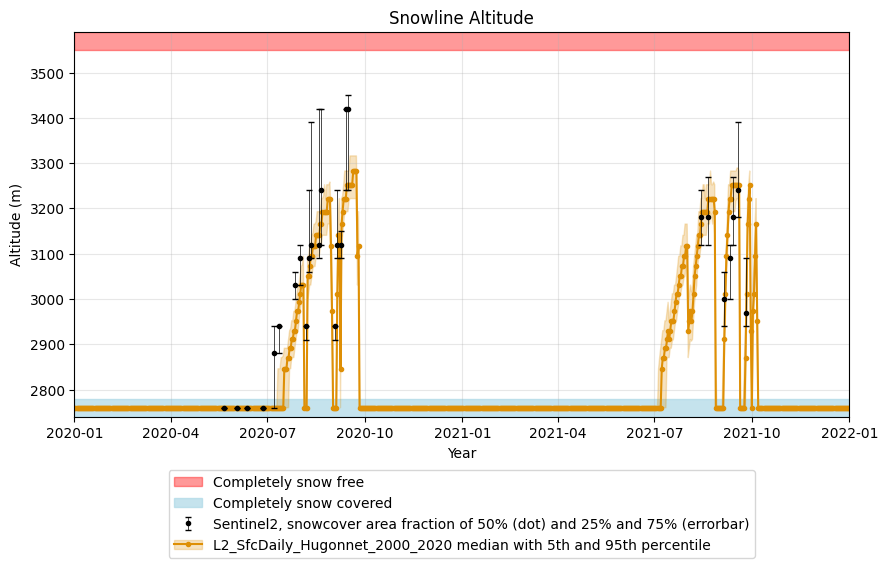

In [23]:
validator_aut.get_validation_plot_for_layers(l2_name_list=l2_list_aut, obs_name='Sentinel2',
                                             x_lim=[2020, 2022])
plt.show()